Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lbi07rei because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [3]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [4]:
df['age']

0       1979.0
1       1996.0
2       1920.0
3       1950.0
4       1962.0
         ...  
2175    1960.0
2176    1957.0
2177    1993.0
2178    1900.0
2179    2014.0
Name: age, Length: 2180, dtype: float64

In [5]:
df.drop(columns=['CNN_age_bracket'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
0,v0.1-NLD.1.10_1-17736,NL_lod12_2d_pand_2,188.713451,99.066126,0.307461,0.653680,POINT (4083580.479654489 3333707.4240016947),343.163256,8ac86811,2801.0,...,8.0,0.304629,[17736],0.478602,9.425303e+05,2.917612e+06,0.610226,4.824422e+05,NaN,f73dc321
1,v0.1-NLD.1.10_1-600,NL_lod12_2d_pand_2,7.062650,429.739587,0.219299,0.687049,POINT (4086116.878775258 3344152.18029182),343.163256,ee52404d,2801.0,...,16.0,0.202944,[600],0.413080,9.425303e+05,2.917612e+06,0.457780,8.039573e+06,NaN,d193281a
2,v0.1-NLD.1.11_1-12526,NL_lod12_2d_pand_2,164.976700,144.561373,0.056066,0.703262,POINT (4090009.4122900637 3337251.0130368765),424.396815,9c5823f2,3121.0,...,16.0,0.056066,[12526],0.338161,8.887122e+05,2.887787e+06,0.639335,6.976209e+05,NaN,547d1be9
3,v0.1-NLD.1.11_1-3618,NL_lod12_2d_pand_2,35.247520,173.828378,0.157550,0.646924,POINT (4099129.2054554615 3336843.490934443),424.396815,2cd884f5,3121.0,...,66.0,0.093344,"[3618, 16325]",0.401968,8.887122e+05,2.887787e+06,0.464323,1.617025e+06,NaN,d2b16a1a
4,v0.1-NLD.1.1_1-10449,NL_lod12_2d_pand_2,36.700821,194.577207,0.223453,0.650665,POINT (4095885.460227467 3325079.0366678457),318.422938,9fe234ff,2369.0,...,57.0,0.091581,[10449],0.383694,1.013007e+06,2.966798e+06,0.599796,3.942082e+06,NaN,116d37d8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175,v0.1-FRA.9.4.2.3_1-3905,BATIMENT-normandie,75.262391,228.969825,0.104087,0.625821,POINT (3587552.141770073 2898333.8640642613),574.200790,4ae5508c,987.0,...,33.0,0.095737,"[3904, 3906, 3905, 3907, 3908]",0.445677,2.095098e+05,1.108007e+06,0.562009,2.867146e+05,non-residential,eccc90af
2176,v0.1-FRA.9.4.2.3_1-3991,BATIMENT-normandie,14.927639,151.276528,0.135573,0.642664,POINT (3586662.962025278 2898392.6864858274),574.200790,22036c2d,987.0,...,58.0,0.046911,[3991],0.393221,2.095098e+05,1.108007e+06,0.452302,3.187626e+04,residential,eccc90af
2177,v0.1-FRA.9.5.1.16_1-5780,BATIMENT-normandie,34.611028,191.478472,0.152696,0.631197,POINT (3706361.968952421 2993498.1461346475),220.225364,d3018bb1,2288.0,...,19.0,0.047995,[5780],0.309286,7.890377e+05,1.863695e+06,0.584843,2.051377e+06,residential,b45a4bce
2178,v0.1-FRA.9.5.1.17_1-11325,BATIMENT-normandie,95.122765,71.723334,0.058543,0.595460,POINT (3675422.1612135097 3016905.248674445),335.660743,05c134d3,3208.0,...,40.0,0.032610,[11325],0.400921,7.053070e+05,2.097088e+06,0.403280,2.137725e+06,residential,d393b4c6


In [6]:
df = df.rename(columns={'age': 'age_right'})


In [7]:
print(len(df))

2180


## Prediction

In [8]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-04-03 08:54:09,007 | INFO : Dataset length: 2180
2024-04-03 08:54:09,013 | INFO : Dataset allocated memory: 2 MB
2024-04-03 08:54:09,016 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-fca318fc.abort.
2024-04-03 08:54:09,017 | INFO : Dataset standard deviation: 32.188492579959444
2024-04-03 08:54:09,018 | INFO : Dataset mean age: 1962.4619266055047
2024-04-03 08:54:09,018 | INFO : Training dataset length: 1744
2024-04-03 08:54:09,019 | INFO : Test dataset length: 436
2024-04-03 08:54:09,031 | INFO : Test dataset standard deviation after preprocessing: 30.174736062922367
2024-04-03 08:54:09,032 | INFO : Test dataset mean age after preprocessing: 1962.6746987951808
2024-04-03 08:54:09,032 | INFO : Training dataset length after preprocessing: 1679
2024-04-03 08:54:09,033 | INFO : Test dataset length after preprocessing: 415
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, 

MAE: 19.86 y
RMSE: 25.13 y
R2: 0.3050
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


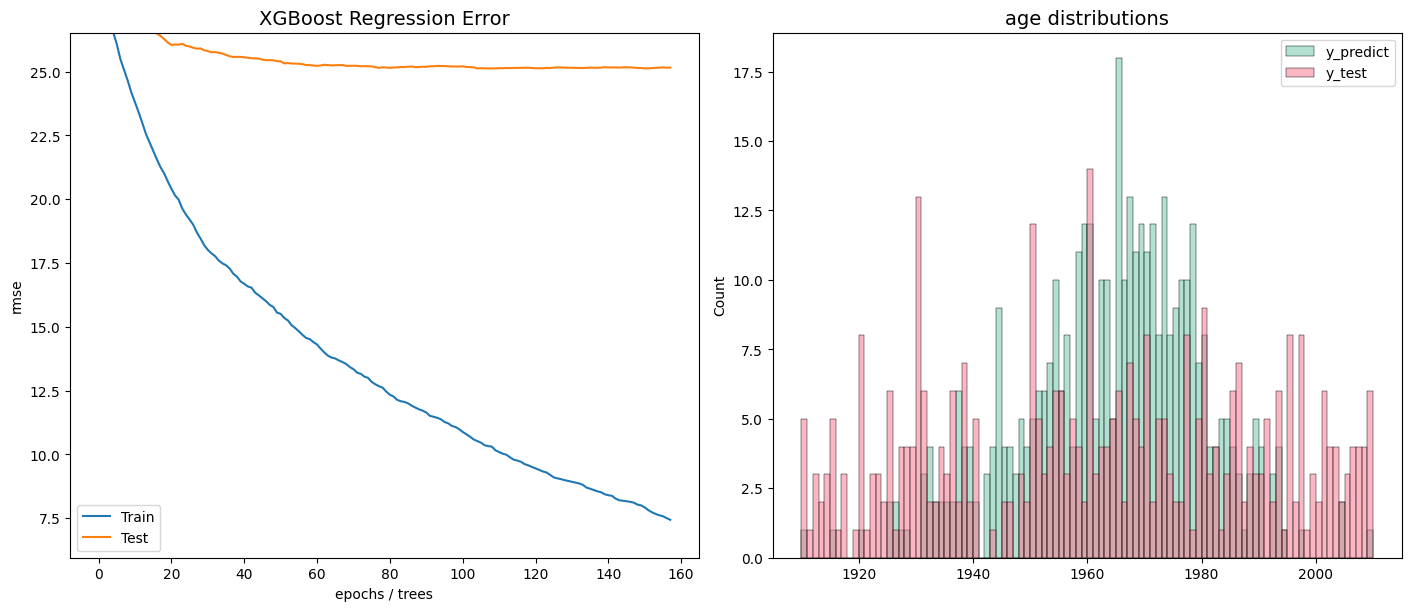

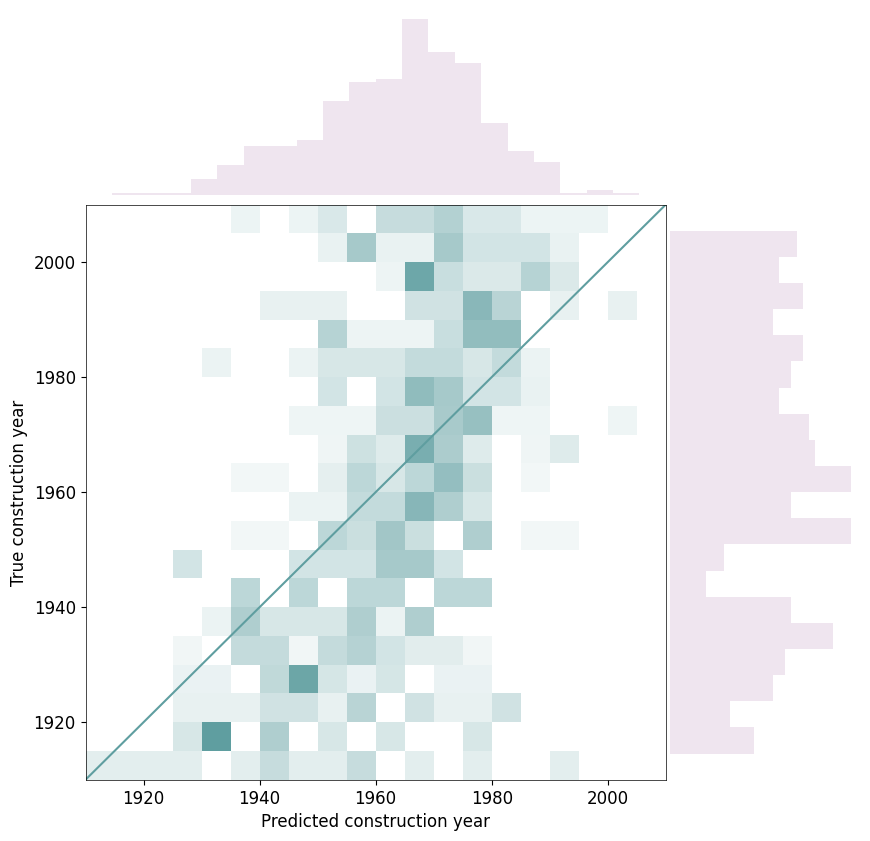

In [9]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


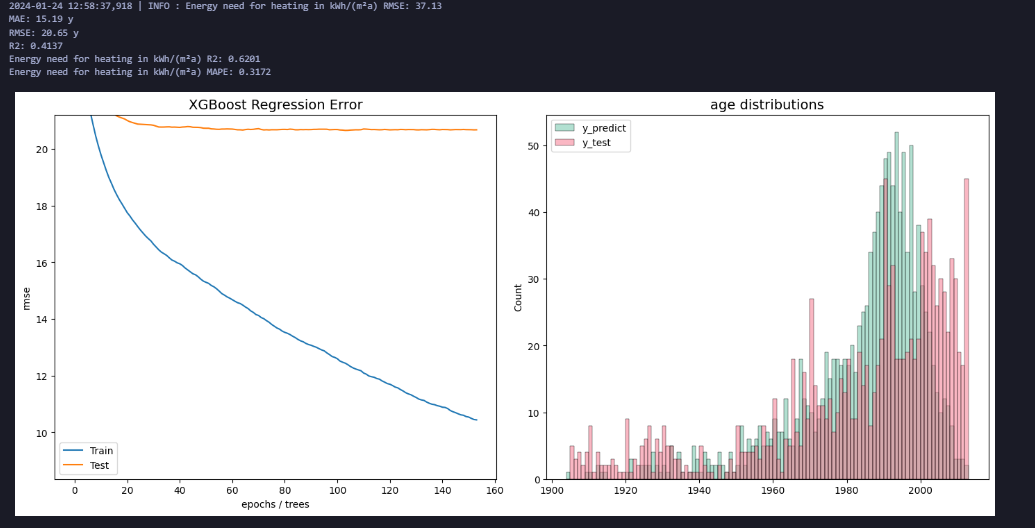
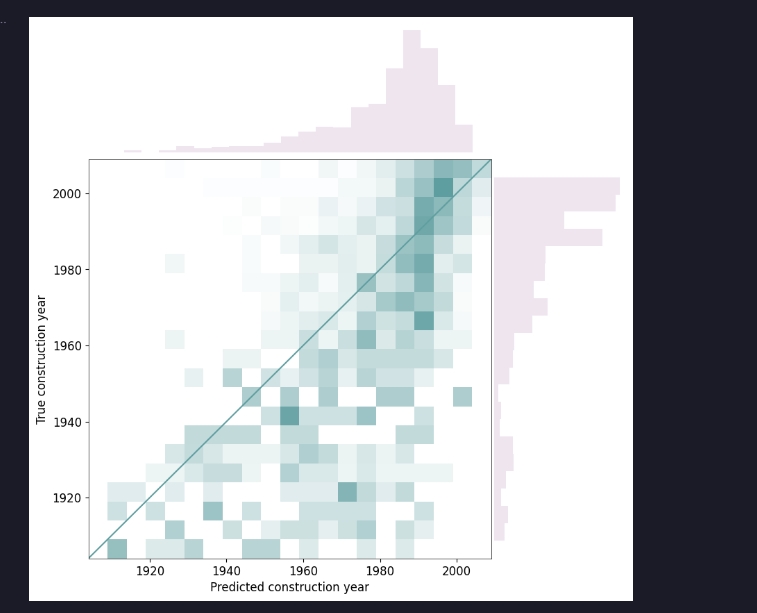

### Classification

2024-04-03 08:54:25,393 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-04-03 08:54:25,394 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-04-03 08:54:25,399 | INFO : Dataset length: 2180
2024-04-03 08:54:25,405 | INFO : Dataset allocated memory: 2 MB
2024-04-03 08:54:25,408 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-371e6c58.abort.
2024-04-03 08:54:25,409 | INFO : Training dataset length: 1744
2024-04-03 08:54:25,410 | INFO : Test dataset length: 436
2024-04-03 08:54:25,411 | INFO : Test cities: ['Alcubilla de Avellaneda' 'Le Mans' 'Stadskanaal' 'Almelo' 'Margraten'
 'Hellendoorn' 'San Esteban de Gormaz' 'Barcelona' 'Groningen' 'Sluis'
 'Boiro' 'Venlo' "Les Sables-d'Olonne" 'BescanÃ³' 'Diemen'
 "'s-Hertogenbosch" 'Sant Pere de Ribes' 'Ede' 'Madrid' 'Amsterdam'
 'Lesparre-MÃ©doc' 'Bordeaux' 'Nunspeet' 'Breuk

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
               precision    recall  f1-score  support
1900-1964      0.695652  0.830189  0.756989      212
1965-1974      0.461538  0.255319  0.328767       47
1975-1991      0.328947  0.367647  0.347222       68
1992-2005      0.250000  0.211538  0.229167       52
2006-2014      0.466667  0.225806  0.304348       31
2015-2021      0.000000  0.000000  0.000000        5
accuracy       0.556627  0.556627  0.556627        0
macro avg      0.367134  0.315083  0.327749      415
weighted avg   0.527724  0.556627  0.532280      415
Cohen’s kappa: 0.3023
Matthews correlation coefficient (MCC): 0.3068


FixedFormatter should only be used together with FixedLocator


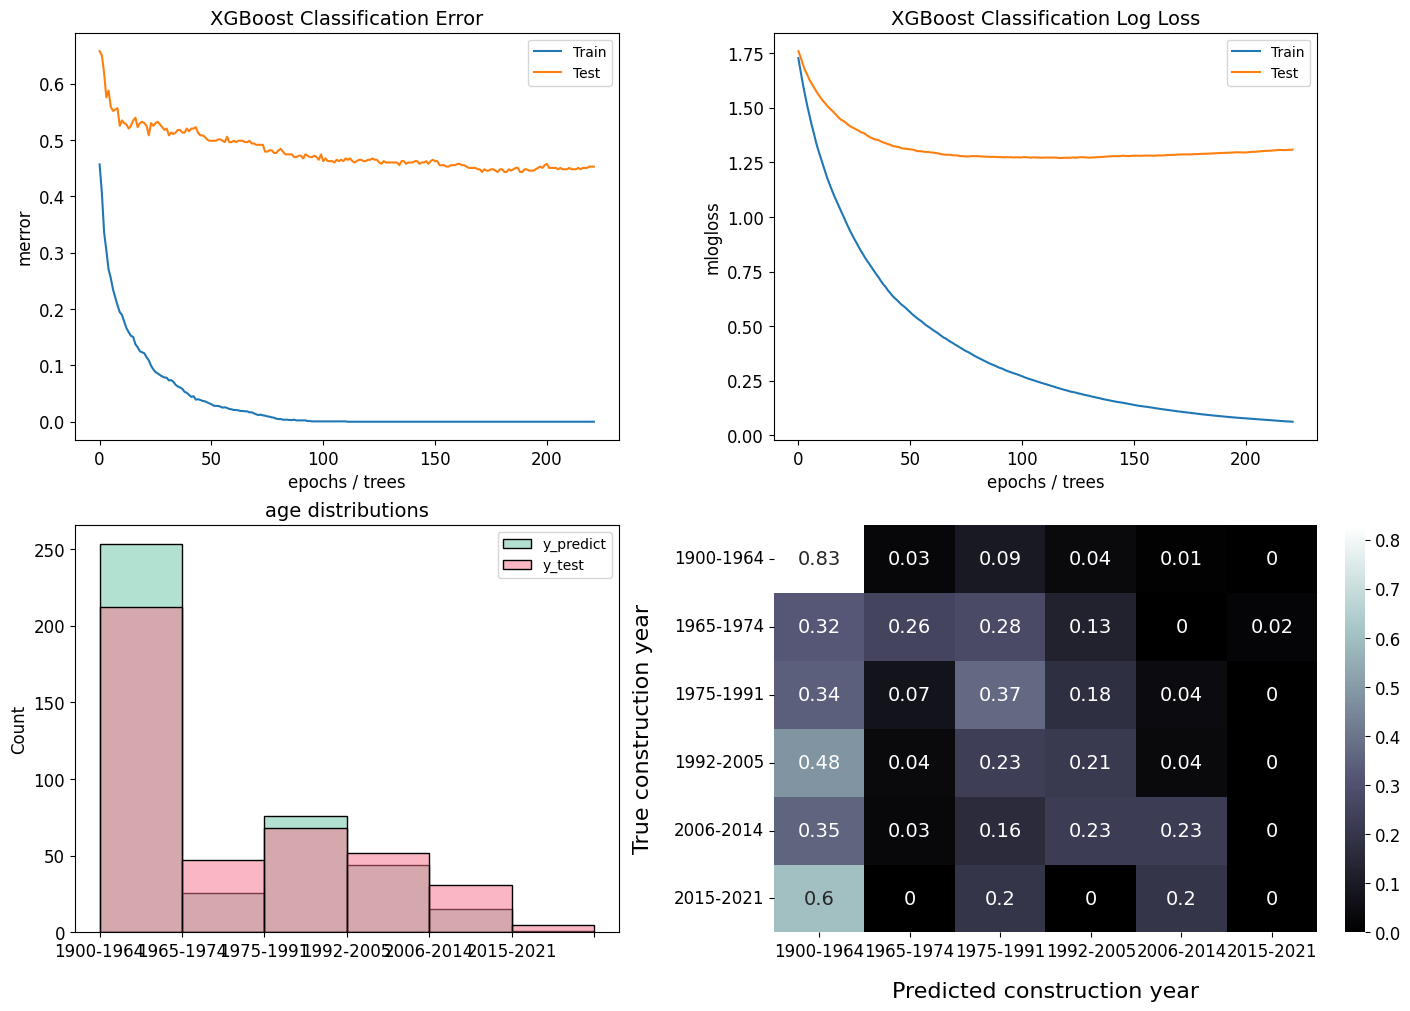

In [10]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

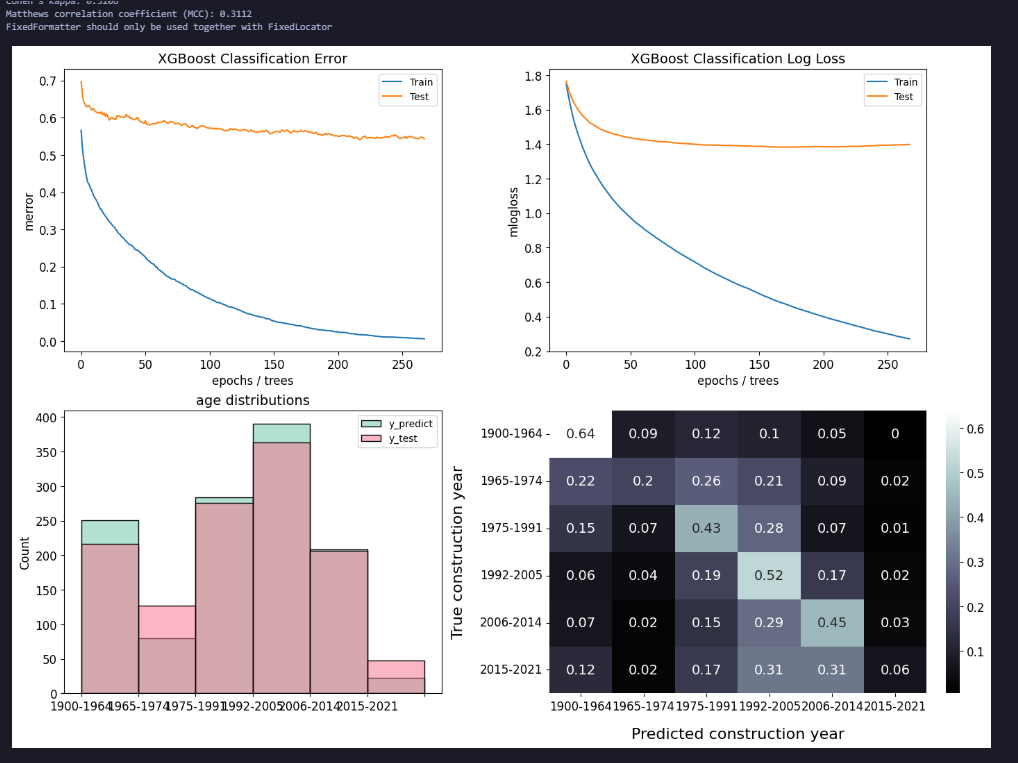

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()